# 🎯 재채기 탐지 경량화 모델

## 목표
- Raspberry Pi / Jetson Nano 등 임베디드 시스템에서 실시간 처리 가능한 경량 모델
- 개선된 Negative 샘플 (생활 소음)
- 데이터 증강으로 성능 향상
- MFCC 기반 효율적 특징 추출

## 파이프라인
1. 데이터 재구성 (생활 소음 중심 Negative 샘플)
2. 데이터 증강
3. PyTorch Dataset/DataLoader
4. 경량 CNN 모델
5. 학습 및 평가

## 1. 라이브러리 임포트

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchaudio
import polars as pl

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import os
import random
import json

# 시드 고정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 경로 설정
ESC50_AUDIO_PATH = "./esc-50/audio/"
ESC50_META_PATH = "./esc-50/meta/esc50.csv"
SNEEZE_AUDIO_PATH = "./datasets/"
MODEL_SAVE_PATH = "./models/"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

Using device: cpu


## 2. ESC-50 데이터셋 분석 및 카테고리 선택

In [2]:
# ESC-50 메타데이터 로드
desc_csv = pl.read_csv(ESC50_META_PATH)

# 생활 소음 관련 카테고리 정의
LIFE_NOISE_CATEGORIES = [
    'coughing', 'breathing', 'laughing', 'crying_baby',
    'footsteps', 'door_wood_knock', 'clapping',
    'keyboard_typing', 'drinking_sipping', 'brushing_teeth',
]

# 존재하는 카테고리만 필터링
all_categories = desc_csv['category'].unique().to_list()
LIFE_NOISE_CATEGORIES = [cat for cat in LIFE_NOISE_CATEGORIES if cat in all_categories]

print(f"선택된 생활 소음 카테고리 ({len(LIFE_NOISE_CATEGORIES)}개):")
for cat in LIFE_NOISE_CATEGORIES:
    count = len(desc_csv.filter(pl.col('category') == cat))
    print(f"  - {cat}: {count} samples")

선택된 생활 소음 카테고리 (10개):
  - coughing: 40 samples
  - breathing: 40 samples
  - laughing: 40 samples
  - crying_baby: 40 samples
  - footsteps: 40 samples
  - door_wood_knock: 40 samples
  - clapping: 40 samples
  - keyboard_typing: 40 samples
  - drinking_sipping: 40 samples
  - brushing_teeth: 40 samples


## 3. 데이터 로딩 함수

In [3]:
def load_audio(file_path, target_sr=16000, target_length=32000):
    audio, sr = torchaudio.load(file_path)
    if sr != target_sr:
        resampler = torchaudio.transforms.Resample(sr, target_sr)
        audio = resampler(audio)
    if audio.shape[0] > 1:
        audio = torch.mean(audio, dim=0, keepdim=True)
    if audio.shape[1] > target_length:
        audio = audio[:, :target_length]
    elif audio.shape[1] < target_length:
        audio = F.pad(audio, (0, target_length - audio.shape[1]))
    return audio.numpy().flatten()

def load_sneeze_dataset(audio_path):
    files = [f for f in os.listdir(audio_path) if f.endswith('.wav')]
    dataset = []
    for f in tqdm(files, desc="Sneeze"):
        dataset.append(load_audio(os.path.join(audio_path, f)))
    return dataset

def load_life_noise_dataset(esc_path, meta_path, categories, max_samples=None):
    csv = pl.read_csv(meta_path)
    filtered = csv.filter(pl.col('category').is_in(categories))
    if max_samples and len(filtered) > max_samples:
        filtered = filtered.sample(n=max_samples, seed=SEED)
    dataset = []
    for row in tqdm(filtered.iter_rows(), total=len(filtered), desc="Life Noise"):
        dataset.append(load_audio(os.path.join(esc_path, row[0])))
    return dataset

# 데이터 로드
print("="*70)
print("데이터 로딩")
print("="*70)
sneeze_samples = load_sneeze_dataset(SNEEZE_AUDIO_PATH)
life_noise_samples = load_life_noise_dataset(
    ESC50_AUDIO_PATH, ESC50_META_PATH, LIFE_NOISE_CATEGORIES,
    max_samples=len(sneeze_samples)
)
print(f"Sneeze: {len(sneeze_samples)}, Life Noise: {len(life_noise_samples)}")

데이터 로딩


Sneeze:   0%|          | 0/968 [00:00<?, ?it/s]/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Pleas

Sneeze: 968, Life Noise: 400


## 4. 데이터 증강

In [4]:
def time_stretch(audio, rate_range=(0.8, 1.2)):
    rate = np.random.uniform(*rate_range)
    stretched = librosa.effects.time_stretch(audio, rate=rate)
    if len(stretched) > len(audio):
        return stretched[:len(audio)]
    else:
        return np.pad(stretched, (0, len(audio) - len(stretched)))

def pitch_shift(audio, sr=16000, n_steps_range=(-3, 3)):
    n_steps = np.random.uniform(*n_steps_range)
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def add_noise(audio, noise_factor_range=(0.002, 0.01)):
    factor = np.random.uniform(*noise_factor_range)
    return audio + factor * np.random.randn(len(audio))

def time_shift(audio, shift_range=(-0.2, 0.2)):
    shift = int(np.random.uniform(*shift_range) * len(audio))
    return np.roll(audio, shift)

def augment_audio(audio):
    aug_type = np.random.choice(['time_stretch', 'pitch_shift', 'add_noise', 'time_shift'])
    if aug_type == 'time_stretch':
        return time_stretch(audio)
    elif aug_type == 'pitch_shift':
        return pitch_shift(audio)
    elif aug_type == 'add_noise':
        return add_noise(audio)
    else:
        return time_shift(audio)

# 데이터 증강 적용
print("데이터 증강 중...")
sneeze_aug = [augment_audio(a) for a in tqdm(sneeze_samples, desc="Sneeze Aug")]
life_aug = [augment_audio(a) for a in tqdm(life_noise_samples, desc="Life Aug")]

all_sneeze = sneeze_samples + sneeze_aug
all_life_noise = life_noise_samples + life_aug
print(f"증강 후: Sneeze {len(all_sneeze)}, Life Noise {len(all_life_noise)}")

데이터 증강 중...


Life Aug: 100%|██████████| 400/400 [00:01<00:00, 217.66it/s]

증강 후: Sneeze 1936, Life Noise 800


## 5. MFCC 특성 추출

In [5]:
def preprocess_audio(audio):
    rms = np.sqrt(np.mean(audio**2))
    if rms > 0:
        audio = audio / rms * 0.1
    pre_emphasis = 0.97
    audio = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])
    audio_trimmed, _ = librosa.effects.trim(audio, top_db=20)
    if len(audio_trimmed) < len(audio):
        audio_trimmed = np.pad(audio_trimmed, (0, len(audio) - len(audio_trimmed)))
    elif len(audio_trimmed) > len(audio):
        audio_trimmed = audio_trimmed[:len(audio)]
    return audio_trimmed

def extract_mfcc_features(audio, n_mfcc=20, include_deltas=True):
    mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=n_mfcc, n_fft=2048, hop_length=512)
    mfcc = mfcc - np.mean(mfcc, axis=1, keepdims=True)
    if include_deltas:
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc = np.vstack([mfcc, delta, delta2])
    return mfcc

# MFCC 추출
print("MFCC 추출 중...")
mfcc_sneeze = []
for a in tqdm(all_sneeze, desc="Sneeze MFCC"):
    mfcc_sneeze.append(extract_mfcc_features(preprocess_audio(a)))

mfcc_life = []
for a in tqdm(all_life_noise, desc="Life MFCC"):
    mfcc_life.append(extract_mfcc_features(preprocess_audio(a)))

print(f"MFCC shape: {mfcc_sneeze[0].shape}")

MFCC 추출 중...


Life MFCC: 100%|██████████| 800/800 [00:07<00:00, 101.36it/s]

MFCC shape: (60, 63)


## 6. 데이터 시각화

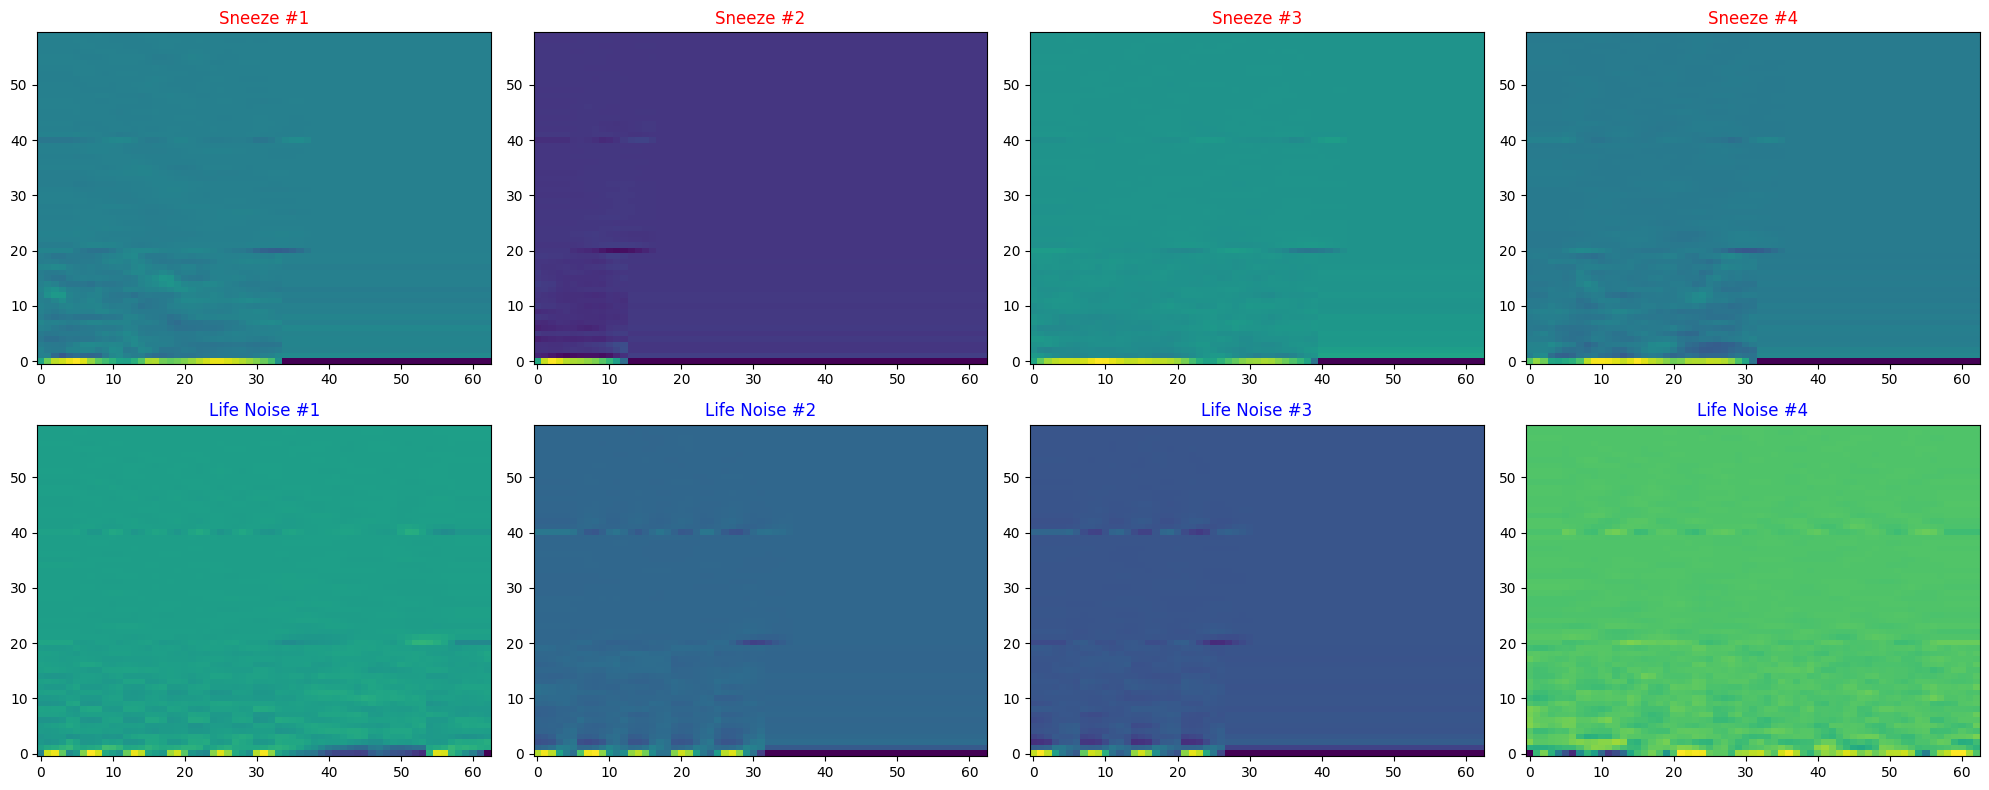

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for i in range(4):
    axes[0, i].imshow(mfcc_sneeze[i], aspect='auto', origin='lower', cmap='viridis')
    axes[0, i].set_title(f'Sneeze #{i+1}', color='red')
    axes[1, i].imshow(mfcc_life[i], aspect='auto', origin='lower', cmap='viridis')
    axes[1, i].set_title(f'Life Noise #{i+1}', color='blue')
plt.tight_layout()
plt.show()

## 7. PyTorch Dataset 및 DataLoader

In [7]:
class SneezeDataset(Dataset):
    def __init__(self, mfcc_list, labels):
        self.mfcc_list = mfcc_list
        self.labels = labels
    
    def __len__(self):
        return len(self.mfcc_list)
    
    def __getitem__(self, idx):
        mfcc = torch.FloatTensor(self.mfcc_list[idx]).unsqueeze(0)
        label = torch.LongTensor([self.labels[idx]])
        return mfcc, label

# 데이터셋 준비
all_mfcc = mfcc_sneeze + mfcc_life
all_labels = [1]*len(mfcc_sneeze) + [0]*len(mfcc_life)

# Train/Val/Test 분할
train_mfcc, temp_mfcc, train_labels, temp_labels = train_test_split(
    all_mfcc, all_labels, test_size=0.3, random_state=SEED, stratify=all_labels
)
val_mfcc, test_mfcc, val_labels, test_labels = train_test_split(
    temp_mfcc, temp_labels, test_size=0.5, random_state=SEED, stratify=temp_labels
)

# DataLoader
BATCH_SIZE = 32
train_loader = DataLoader(SneezeDataset(train_mfcc, train_labels), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(SneezeDataset(val_mfcc, val_labels), batch_size=BATCH_SIZE)
test_loader = DataLoader(SneezeDataset(test_mfcc, test_labels), batch_size=BATCH_SIZE)

print(f"Train: {len(train_mfcc)}, Val: {len(val_mfcc)}, Test: {len(test_mfcc)}")

Train: 1915, Val: 410, Test: 411


## 8. 경량 CNN 모델

In [8]:
class LightweightSneezeCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Depthwise Separable Conv Blocks
        self.conv1_dw = nn.Conv2d(1, 1, 3, padding=1, groups=1)
        self.conv1_pw = nn.Conv2d(1, 32, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2_dw = nn.Conv2d(32, 32, 3, padding=1, groups=32)
        self.conv2_pw = nn.Conv2d(32, 64, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3_dw = nn.Conv2d(64, 64, 3, padding=1, groups=64)
        self.conv3_pw = nn.Conv2d(64, 128, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 2)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1_pw(self.conv1_dw(x))))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2_pw(self.conv2_dw(x))))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3_pw(self.conv3_dw(x))))
        x = self.pool3(x)
        x = self.gap(x).view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

model = LightweightSneezeCNN().to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"모델 파라미터: {total_params:,}개 (~{total_params*4/1024/1024:.2f} MB)")

모델 파라미터: 20,300개 (~0.08 MB)


## 9. 학습 설정

In [9]:
NUM_EPOCHS = 50
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print(f"학습 준비 완료: {NUM_EPOCHS} epochs, LR={LEARNING_RATE}")

학습 준비 완료: 50 epochs, LR=0.001


## 10. 학습 루프

In [10]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(loader, desc="Train"):
        inputs, labels = inputs.to(device), labels.squeeze().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        _, pred = torch.max(outputs, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Val"):
            inputs, labels = inputs.to(device), labels.squeeze().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, pred = torch.max(outputs, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss / total, correct / total, all_preds, all_labels

# 학습
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'best_model.pth'))
        print(f"✓ Best model saved! (Acc: {val_acc*100:.2f}%)")

print(f"\n학습 완료! Best Val Acc: {best_val_acc*100:.2f}%")


Epoch 1/50


Val: 100%|██████████| 13/13 [00:00<00:00, 35.76it/s]


Train Loss: 0.4519, Acc: 78.59%
Val Loss: 0.3268, Acc: 86.34%
✓ Best model saved! (Acc: 86.34%)

Epoch 2/50


Val: 100%|██████████| 13/13 [00:00<00:00, 32.38it/s]


Train Loss: 0.3013, Acc: 87.42%
Val Loss: 0.2458, Acc: 89.02%
✓ Best model saved! (Acc: 89.02%)

Epoch 3/50


Val: 100%|██████████| 13/13 [00:00<00:00, 36.10it/s]


Train Loss: 0.2617, Acc: 89.30%
Val Loss: 0.3369, Acc: 86.10%

Epoch 4/50


Val: 100%|██████████| 13/13 [00:00<00:00, 36.53it/s]


Train Loss: 0.2440, Acc: 89.92%
Val Loss: 0.2388, Acc: 90.49%
✓ Best model saved! (Acc: 90.49%)

Epoch 5/50


Val: 100%|██████████| 13/13 [00:00<00:00, 28.47it/s]


Train Loss: 0.2498, Acc: 89.50%
Val Loss: 0.2241, Acc: 91.71%
✓ Best model saved! (Acc: 91.71%)

Epoch 6/50


Val: 100%|██████████| 13/13 [00:00<00:00, 35.50it/s]


Train Loss: 0.2251, Acc: 90.97%
Val Loss: 0.2056, Acc: 91.46%

Epoch 7/50


Val: 100%|██████████| 13/13 [00:00<00:00, 36.05it/s]


Train Loss: 0.2349, Acc: 89.92%
Val Loss: 0.2576, Acc: 90.73%

Epoch 8/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.80it/s]


Train Loss: 0.2080, Acc: 91.12%
Val Loss: 0.2020, Acc: 92.20%
✓ Best model saved! (Acc: 92.20%)

Epoch 9/50


Val: 100%|██████████| 13/13 [00:00<00:00, 33.84it/s]


Train Loss: 0.2014, Acc: 92.48%
Val Loss: 0.2390, Acc: 88.54%

Epoch 10/50


Val: 100%|██████████| 13/13 [00:00<00:00, 31.89it/s]


Train Loss: 0.1870, Acc: 92.27%
Val Loss: 0.2077, Acc: 91.22%

Epoch 11/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.64it/s]


Train Loss: 0.1907, Acc: 91.59%
Val Loss: 0.3282, Acc: 84.15%

Epoch 12/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.61it/s]


Train Loss: 0.1979, Acc: 91.96%
Val Loss: 0.1976, Acc: 92.93%
✓ Best model saved! (Acc: 92.93%)

Epoch 13/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.04it/s]


Train Loss: 0.1748, Acc: 92.74%
Val Loss: 0.4339, Acc: 82.20%

Epoch 14/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.36it/s]


Train Loss: 0.1640, Acc: 93.73%
Val Loss: 0.3461, Acc: 84.15%

Epoch 15/50


Val: 100%|██████████| 13/13 [00:00<00:00, 30.48it/s]


Train Loss: 0.1598, Acc: 93.42%
Val Loss: 0.2877, Acc: 86.59%

Epoch 16/50


Val: 100%|██████████| 13/13 [00:00<00:00, 26.00it/s]


Train Loss: 0.1644, Acc: 92.85%
Val Loss: 0.2131, Acc: 90.24%

Epoch 17/50


Val: 100%|██████████| 13/13 [00:00<00:00, 35.02it/s]


Train Loss: 0.1388, Acc: 94.99%
Val Loss: 0.4001, Acc: 85.61%

Epoch 18/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.60it/s]


Train Loss: 0.1582, Acc: 93.99%
Val Loss: 0.1931, Acc: 92.93%

Epoch 19/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.60it/s]


Train Loss: 0.1385, Acc: 95.30%
Val Loss: 0.2884, Acc: 85.61%

Epoch 20/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.94it/s]


Train Loss: 0.1524, Acc: 94.31%
Val Loss: 0.4422, Acc: 82.44%

Epoch 21/50


Val: 100%|██████████| 13/13 [00:00<00:00, 29.13it/s]


Train Loss: 0.1305, Acc: 95.40%
Val Loss: 0.2554, Acc: 88.78%

Epoch 22/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.38it/s]


Train Loss: 0.1230, Acc: 95.04%
Val Loss: 0.2589, Acc: 90.98%

Epoch 23/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.86it/s]


Train Loss: 0.0990, Acc: 96.40%
Val Loss: 0.1795, Acc: 94.63%
✓ Best model saved! (Acc: 94.63%)

Epoch 24/50


Val: 100%|██████████| 13/13 [00:00<00:00, 33.84it/s]


Train Loss: 0.1146, Acc: 95.61%
Val Loss: 0.1965, Acc: 92.68%

Epoch 25/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.66it/s]


Train Loss: 0.1127, Acc: 95.87%
Val Loss: 0.2792, Acc: 89.27%

Epoch 26/50


Val: 100%|██████████| 13/13 [00:00<00:00, 20.68it/s]


Train Loss: 0.1028, Acc: 96.24%
Val Loss: 0.2768, Acc: 89.51%

Epoch 27/50


Val: 100%|██████████| 13/13 [00:00<00:00, 35.50it/s]


Train Loss: 0.1417, Acc: 94.57%
Val Loss: 0.2117, Acc: 92.68%

Epoch 28/50


Val: 100%|██████████| 13/13 [00:00<00:00, 35.57it/s]


Train Loss: 0.0982, Acc: 96.24%
Val Loss: 0.5814, Acc: 80.24%

Epoch 29/50


Val: 100%|██████████| 13/13 [00:00<00:00, 28.44it/s]


Train Loss: 0.0910, Acc: 96.55%
Val Loss: 0.2643, Acc: 91.95%

Epoch 30/50


Val: 100%|██████████| 13/13 [00:00<00:00, 35.89it/s]


Train Loss: 0.0767, Acc: 97.44%
Val Loss: 0.1751, Acc: 93.41%

Epoch 31/50


Val: 100%|██████████| 13/13 [00:00<00:00, 28.63it/s]


Train Loss: 0.0681, Acc: 98.02%
Val Loss: 0.1731, Acc: 93.41%

Epoch 32/50


Val: 100%|██████████| 13/13 [00:00<00:00, 35.67it/s]


Train Loss: 0.0652, Acc: 97.96%
Val Loss: 0.1993, Acc: 93.41%

Epoch 33/50


Val: 100%|██████████| 13/13 [00:00<00:00, 35.56it/s]


Train Loss: 0.0590, Acc: 98.07%
Val Loss: 0.1883, Acc: 93.66%

Epoch 34/50


Val: 100%|██████████| 13/13 [00:00<00:00, 20.92it/s]


Train Loss: 0.0591, Acc: 98.38%
Val Loss: 0.1865, Acc: 94.15%

Epoch 35/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.90it/s]


Train Loss: 0.0622, Acc: 97.81%
Val Loss: 0.5866, Acc: 84.39%

Epoch 36/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.02it/s]


Train Loss: 0.0591, Acc: 97.91%
Val Loss: 0.1861, Acc: 93.90%

Epoch 37/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.10it/s]


Train Loss: 0.0484, Acc: 98.54%
Val Loss: 0.2539, Acc: 92.44%

Epoch 38/50


Val: 100%|██████████| 13/13 [00:00<00:00, 32.77it/s]


Train Loss: 0.0449, Acc: 98.75%
Val Loss: 0.1933, Acc: 93.90%

Epoch 39/50


Val: 100%|██████████| 13/13 [00:00<00:00, 33.24it/s]


Train Loss: 0.0402, Acc: 98.85%
Val Loss: 0.1832, Acc: 94.15%

Epoch 40/50


Val: 100%|██████████| 13/13 [00:00<00:00, 32.58it/s]


Train Loss: 0.0412, Acc: 98.90%
Val Loss: 0.1884, Acc: 93.66%

Epoch 41/50


Val: 100%|██████████| 13/13 [00:00<00:00, 24.93it/s]


Train Loss: 0.0366, Acc: 99.11%
Val Loss: 0.2055, Acc: 92.93%

Epoch 42/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.10it/s]


Train Loss: 0.0328, Acc: 99.37%
Val Loss: 0.1987, Acc: 93.66%

Epoch 43/50


Val: 100%|██████████| 13/13 [00:00<00:00, 33.10it/s]


Train Loss: 0.0344, Acc: 98.75%
Val Loss: 0.2334, Acc: 91.46%

Epoch 44/50


Val: 100%|██████████| 13/13 [00:00<00:00, 32.90it/s]


Train Loss: 0.0325, Acc: 99.16%
Val Loss: 0.1919, Acc: 93.90%

Epoch 45/50


Val: 100%|██████████| 13/13 [00:00<00:00, 33.50it/s]


Train Loss: 0.0292, Acc: 99.32%
Val Loss: 0.1994, Acc: 93.66%

Epoch 46/50


Val: 100%|██████████| 13/13 [00:00<00:00, 33.81it/s]


Train Loss: 0.0303, Acc: 99.32%
Val Loss: 0.2008, Acc: 94.15%

Epoch 47/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.25it/s]


Train Loss: 0.0323, Acc: 99.01%
Val Loss: 0.1955, Acc: 94.15%

Epoch 48/50


Val: 100%|██████████| 13/13 [00:00<00:00, 24.94it/s]


Train Loss: 0.0314, Acc: 99.06%
Val Loss: 0.2243, Acc: 93.90%

Epoch 49/50


Val: 100%|██████████| 13/13 [00:00<00:00, 32.76it/s]


Train Loss: 0.0278, Acc: 99.48%
Val Loss: 0.2002, Acc: 93.90%

Epoch 50/50


Val: 100%|██████████| 13/13 [00:00<00:00, 34.27it/s]

Train Loss: 0.0299, Acc: 99.43%
Val Loss: 0.2035, Acc: 94.15%

학습 완료! Best Val Acc: 94.63%


## 11. 학습 결과 시각화

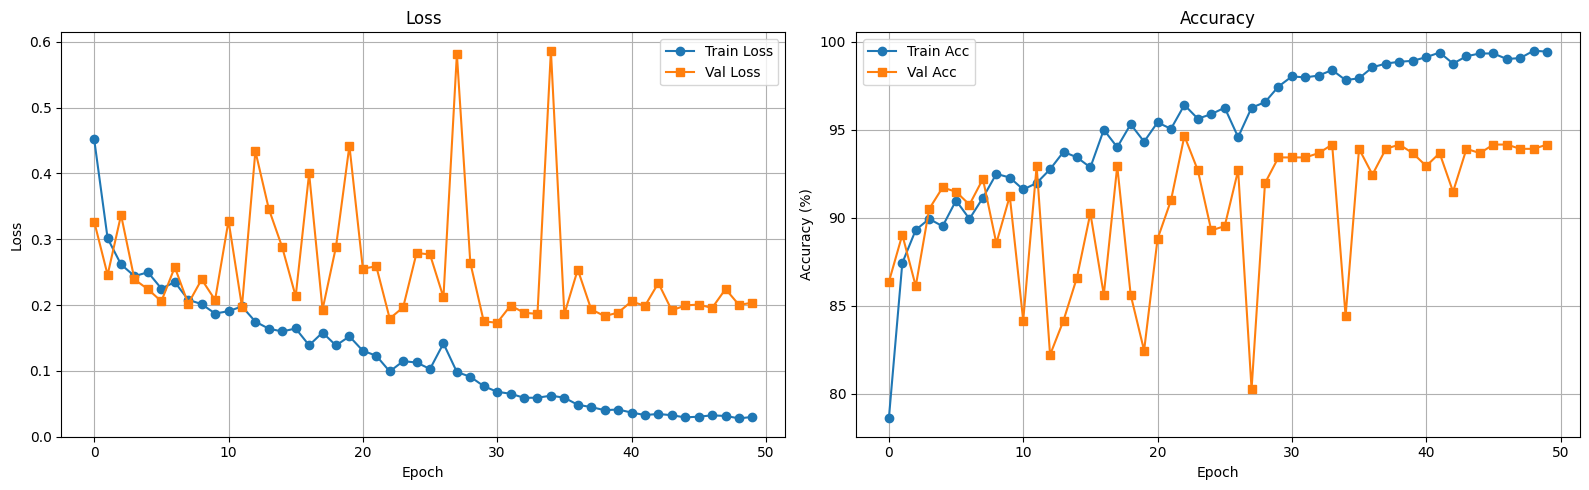

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(history['train_loss'], 'o-', label='Train Loss')
axes[0].plot(history['val_loss'], 's-', label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot([a*100 for a in history['train_acc']], 'o-', label='Train Acc')
axes[1].plot([a*100 for a in history['val_acc']], 's-', label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 12. 테스트 세트 평가

Val: 100%|██████████| 13/13 [00:00<00:00, 33.58it/s]


Test Loss: 0.1507
Test Accuracy: 93.67%

Classification Report:
              precision    recall  f1-score   support

  Life Noise     0.8615    0.9333    0.8960       120
      Sneeze     0.9715    0.9381    0.9545       291

    accuracy                         0.9367       411
   macro avg     0.9165    0.9357    0.9253       411
weighted avg     0.9394    0.9367    0.9375       411



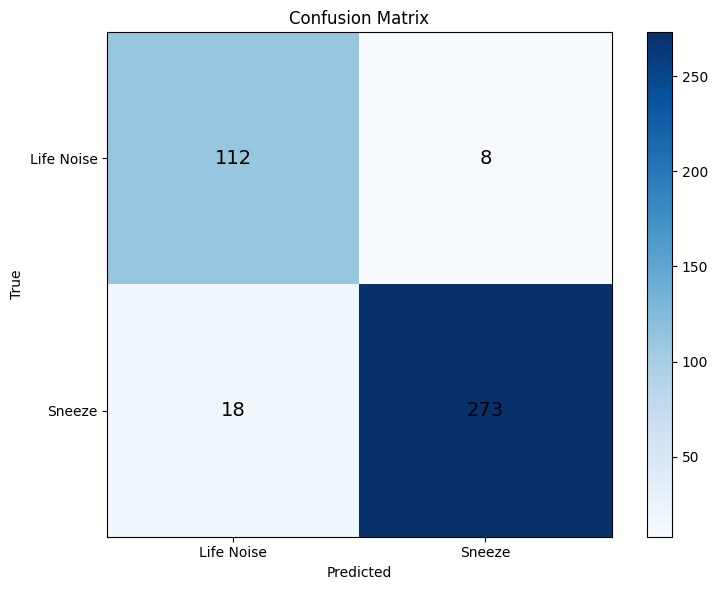

In [12]:
# Best model 로드
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, 'best_model.pth')))

# 테스트
test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, device)

print("="*70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print("="*70)

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['Life Noise', 'Sneeze'], digits=4))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Life Noise', 'Sneeze'])
plt.yticks([0, 1], ['Life Noise', 'Sneeze'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## 13. 모델 Export

In [14]:
# TorchScript
model.eval()
example = torch.randn(1, 1, 60, 63).to(device)
traced = torch.jit.trace(model, example)
traced.save(os.path.join(MODEL_SAVE_PATH, 'sneeze_model_scripted.pt'))

# ONNX
torch.onnx.export(
    model, example,
    os.path.join(MODEL_SAVE_PATH, 'sneeze_model.onnx'),
    input_names=['input'], output_names=['output'],
    dynamic_axes={'input': {0: 'batch'}, 'output': {0: 'batch'}}
)

print("모델 저장 완료!")
print(f"  - PyTorch: best_model.pth")
print(f"  - TorchScript: sneeze_model_scripted.pt")
print(f"  - ONNX: sneeze_model.onnx")

/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_4900/3849052523.py:8: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


모델 저장 완료!
  - PyTorch: best_model.pth
  - TorchScript: sneeze_model_scripted.pt
  - ONNX: sneeze_model.onnx


## 14. 추론 예제

In [15]:
def predict_audio(model, audio_path, device):
    model.eval()
    audio = load_audio(audio_path)
    audio = preprocess_audio(audio)
    mfcc = extract_mfcc_features(audio)
    mfcc_tensor = torch.FloatTensor(mfcc).unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(mfcc_tensor)
        prob = F.softmax(output, dim=1)
        pred = torch.argmax(prob, dim=1).item()
        conf = prob[0][pred].item()
    
    return pred, conf

# 테스트
test_file = os.path.join(SNEEZE_AUDIO_PATH, os.listdir(SNEEZE_AUDIO_PATH)[0])
if test_file.endswith('.wav'):
    pred, conf = predict_audio(model, test_file, device)
    label = "Sneeze" if pred == 1 else "Life Noise"
    print(f"파일: {os.path.basename(test_file)}")
    print(f"예측: {label} (신뢰도: {conf*100:.2f}%)")

파일: sneeze299.wav
예측: Sneeze (신뢰도: 99.21%)


/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3